## Prueba técnica

### Paso 1: Alcance del proyecto

Identificar features e hipótesis a través de descriptivos que permitan construir un modelo analítico que permita evidenciar las transacciones de mala práctica transaccional

### Paso 2: EDA

En el EDA, el propósito principal es entender la base y las variables que se tienen disponibles para hallar los usr con malas prácticas transaccionales. Esta base cuenta con 10.8M de registros del 01 de enero de 2021 hasta el 30 de noviembre de 2021. Durante este periodo de tiempo, 1.9M de usuarios realizaron transacciones, el 50% realiza hasta 2 trx y 460k (24%) usr realizan más de 5 trx.

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

In [2]:
# Carga de datos
df_1 = pd.read_parquet(r'C:\Users\egarcmor\Desktop\Nequi\sample_data_0006_part_00.parquet')


In [3]:
# Preprocesar datos
df_1['fecha'] = pd.to_datetime(df_1['transaction_date'])
df_1['date_1'] = df_1['fecha'].dt.strftime('%Y%m%d').astype(int)
df_1.head()

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha,date_1
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.33365037,CREDITO,2021-09-12 18:32:03,20210912
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.66673007,CREDITO,2021-09-12 18:31:58,20210912
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.66692029,CREDITO,2021-09-12 18:31:56,20210912
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.32223701,CREDITO,2021-09-12 18:31:10,20210912
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.10005706,CREDITO,2021-09-12 18:31:07,20210912


In [4]:
# Características de la base
print("shape", df_1.shape)
print('usr_trx', df_1['user_id'].nunique())
print('trx', df_1['_id'].nunique())
print("cols:", list(df_1.columns))
print("Tipo de datos")
df_1.dtypes

shape (10758418, 10)
usr_trx 1948844
trx 10758411
cols: ['merchant_id', '_id', 'subsidiary', 'transaction_date', 'account_number', 'user_id', 'transaction_amount', 'transaction_type', 'fecha', 'date_1']
Tipo de datos


merchant_id                   object
_id                           object
subsidiary                    object
transaction_date      datetime64[ns]
account_number                object
user_id                       object
transaction_amount            object
transaction_type              object
fecha                 datetime64[ns]
date_1                         int64
dtype: object

In [5]:
# Validación de nulos:
print(df_1.isnull().sum())

merchant_id           0
_id                   0
subsidiary            0
transaction_date      0
account_number        0
user_id               0
transaction_amount    0
transaction_type      0
fecha                 0
date_1                0
dtype: int64


In [6]:
# Transacciones por usr
trx_usr = pd.DataFrame(df_1['user_id'].value_counts()).reset_index()
print(trx_usr.shape)

# usuarios con más de una transacción
trx_usr_obj = trx_usr[trx_usr['count']>1]
print(trx_usr_obj.shape)

trx_usr_obj.head()

(1948844, 2)
(1171465, 2)


,user_id,count
0,5e674596af22a66e826bf15b2a363cce,1900
1,d3720205290ca7444d216167dd4cb0b1,1728
2,e77fc30bb3bec8bf45a35b535b292047,1358
3,09ef9d0c0923b7f4848655f0de449603,1202
4,93bb7c11b0b58e233f56f50cd70c1a82,1200


In [45]:
trx_usr.describe().T

,count,mean,std,min,25%,50%,75%,max
count,1948844.0,5.52041,12.123418,1.0,1.0,2.0,5.0,1900.0


In [47]:
print(trx_usr[trx_usr['count']>5].shape)
print(trx_usr[trx_usr['count']<=5].shape)

(461380, 2)
(1487464, 2)


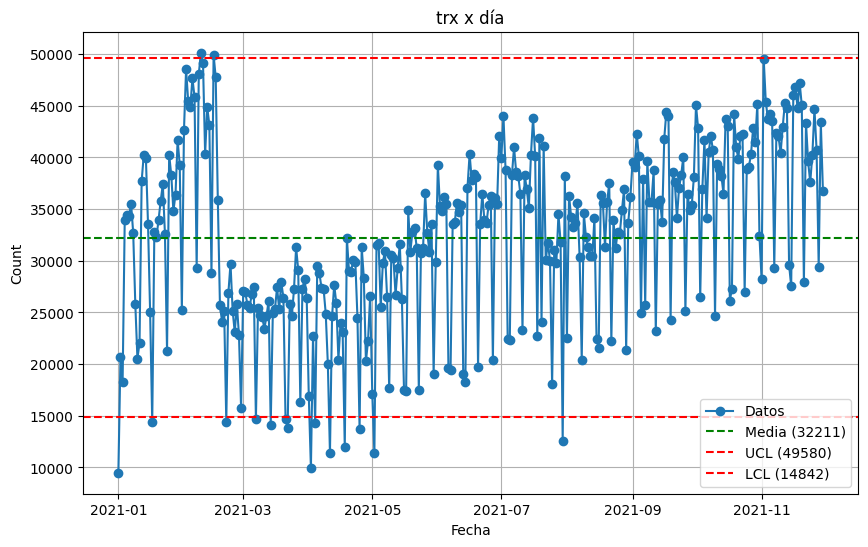

In [7]:
# Transacciones por día
aa = pd.DataFrame(df_1['date_1'].value_counts()).reset_index().sort_values(by='date_1')
aa['date_1'] = pd.to_datetime(aa['date_1'], format='%Y%m%d')

mean = aa['count'].mean()
std = aa['count'].std()
ucl = mean + 2 * std
lcl = mean - 2 * std

plt.figure(figsize=(10,6))
plt.plot(aa['date_1'], aa['count'], marker='o', label='Datos')
plt.axhline(mean, color='green', linestyle='--', label=f'Media ({mean:.0f})')
plt.axhline(ucl, color='red', linestyle='--', label=f'UCL ({ucl:.0f})')
plt.axhline(lcl, color='red', linestyle='--', label=f'LCL ({lcl:.0f})')

plt.title("trx x día")
plt.xlabel("Fecha")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Fechas iniciales
aa.head()

,date_1,count
333,2021-01-01,9492
297,2021-01-02,20737
309,2021-01-03,18265
154,2021-01-04,33959
147,2021-01-05,34423


In [44]:
# Fechas finales
aa.tail()

,date_1,count
22,2021-11-26,44659
55,2021-11-27,40749
211,2021-11-28,29429
32,2021-11-29,43396
108,2021-11-30,36749


#### Paso 2.1: Análisis temporal

Para el análisis temporal vamos a tomar una muestra para un mes. Sobre este vamos a realizar todos los análisis. Para ello, vamos a calcular las trasacciones que se realizan cada usuario por día, el monto y el coeficiente de variación por tipo de transaccioón (Crédito/Débito)

In [8]:
df_1_sample = df_1[df_1['date_1']<20210201].sort_values(by='fecha').copy()
df_1_sample.head()

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha,date_1
2345854,817d18cd3c31e40e9bff0566baae7758,8c2df593436163e9cbff2fe3050f0ae1,c1b186a762110afc5d510517b04b6329,2021-01-01 00:01:13,a49b390b90de1454f966c604da9687d3,8c8b5512b0772dc891bef619ecd2acfb,47.55564009,DEBITO,2021-01-01 00:01:13,20210101
10048636,838a8fa992a4aa2fb5a0cf8b15b63755,6ed538998f04c804c299dc9fbc4d6e90,dff70ce33784a932ce4a7efc81a43863,2021-01-01 00:01:17,666e5e749c3ae3dea220e023a51c88f4,d0a25a8f11f7228d912e6874a0544d41,5.94445501,CREDITO,2021-01-01 00:01:17,20210101
9370118,838a8fa992a4aa2fb5a0cf8b15b63755,8801042a2192cdb8d96074442e5d4e06,d4b31b123120a4eefd51ba95975f2ae4,2021-01-01 00:01:45,c039cca9581596ee863c3c812835bfff,6b6113f0dfead46eb7f0c21ecb78d567,5.94445501,DEBITO,2021-01-01 00:01:45,20210101
9323529,838a8fa992a4aa2fb5a0cf8b15b63755,d7f0eb2060bf7bfb7f2bf7ae909482f9,f54e0b6b32831a6307361ed959903e76,2021-01-01 00:01:56,7cb8b569bc1b2b1a744c9c9c0474fc9f,9771a35cca86b1e5c375116b4cbbab82,5.94683279,CREDITO,2021-01-01 00:01:56,20210101
10097989,838a8fa992a4aa2fb5a0cf8b15b63755,7bbc8ec5d0af79dd960d6a13d1ac501b,d4b31b123120a4eefd51ba95975f2ae4,2021-01-01 00:02:23,c039cca9581596ee863c3c812835bfff,6b6113f0dfead46eb7f0c21ecb78d567,5.94445501,CREDITO,2021-01-01 00:02:23,20210101


In [9]:
# cálculo de las métricas de monitoreo
trx = df_1_sample.groupby(['transaction_type', 'user_id', 'date_1']).agg({
    'transaction_amount': ['count', 'sum', 'mean', 'std'] 
}).reset_index()
trx.columns = ['transaction_type', 'user_id', 'date_1', 'trx_', 'ammnt', 'avg', 'std'] 
trx['ammnt'] = trx['ammnt'].astype('float')
trx['cv'] = trx['std']/trx['avg']
trx['cv'] = trx['cv'].astype('float')
trx['cv'] = trx['cv'].fillna(0)
trx['avg'] = trx['avg'].astype('float')

trx.head()

,transaction_type,user_id,date_1,trx_,ammnt,avg,std,cv
0,CREDITO,000002373d5835d0e53b78722424076f,20210126,1,29.722275,29.722275,NaN,0.0
1,CREDITO,0000ac72b7e9af6ddb4fb8f2632c6dd0,20210106,1,35.666730,35.666730,NaN,0.0
2,CREDITO,0000fa6271f911a5f4800acde409eb0a,20210127,1,28.533384,28.533384,NaN,0.0
3,CREDITO,00016e0ba829ef7aa6ac61b712154adc,20210129,1,118.889100,118.889100,NaN,0.0
4,CREDITO,00037690c2afe2780a91e7430b74e7ce,20210129,1,190.222560,190.222560,NaN,0.0


In [10]:
trx_agg = pd.pivot_table(trx, values=['trx_', 'ammnt'], index=['date_1', 'user_id'], columns=['transaction_type'], aggfunc="sum").reset_index()
trx_agg.columns = ['date_1', 'user_id', 'ammnt_cre', 'ammnt_deb', 'trx_cre', 'trx_deb']
trx_agg['ammnt_cre'] = trx_agg['ammnt_cre'] .fillna(0)
trx_agg['trx_cre'] = trx_agg['trx_cre'] .fillna(0)
trx_agg['ammnt_deb'] = trx_agg['ammnt_deb'] .fillna(0)
trx_agg['trx_deb'] = trx_agg['trx_deb'] .fillna(0)
trx_agg.head()

,date_1,user_id,ammnt_cre,ammnt_deb,trx_cre,trx_deb
0,20210101,0000e1ea905448383169f19acfa9ef5a,0.0,47.555640,0.0,1.0
1,20210101,0013f83d31e20fc44b01c8c28daf918c,0.0,939.223892,0.0,2.0
2,20210101,0038448875bcb1ea2284589df7c4cb47,0.0,178.333650,0.0,2.0
3,20210101,004a121e550cf799563611a3ebec782b,0.0,15.455583,0.0,2.0
4,20210101,005a78af75eedb4cf6afdbe60bf60a50,0.0,17.238920,0.0,1.0


In [11]:
trx_agg.describe()

,date_1,ammnt_cre,ammnt_deb,trx_cre,trx_deb
count,6.206670e+05,620667.000000,620667.000000,620667.000000,620667.000000
mean,2.021012e+07,33.242397,154.098967,0.520980,1.027382
std,8.615605e+00,116.492622,291.524667,2.645675,2.803912
min,2.021010e+07,0.000000,0.000000,0.000000,0.000000
25%,2.021011e+07,0.000000,0.000000,0.000000,0.000000
50%,2.021012e+07,0.000000,59.444550,0.000000,1.000000
75%,2.021012e+07,11.888910,178.333650,1.000000,1.000000
max,2.021013e+07,3070.309825,5231.120411,129.000000,101.000000


#### Paso 2.2: Análisis de Crédito

In [12]:
# Ahora, vamos a caracterizar el ammnt y el cv para aquellos usuarios que realizan más de una transacción
trx_an_cre = trx[(trx['trx_']>1) & (trx['transaction_type']=='CREDITO')].drop(columns=[ 'std'])
print('trx_cre:', trx_an_cre.shape[0])
trx_an_cre.head()

trx_cre: 50498


,transaction_type,user_id,date_1,trx_,ammnt,avg,cv
8,CREDITO,0006d504d524c03952dc4817ba65c43c,20210103,3,52.311204,17.437068,0.039365
9,CREDITO,0006d504d524c03952dc4817ba65c43c,20210104,2,33.288948,16.644474,0.000000
10,CREDITO,0006d504d524c03952dc4817ba65c43c,20210105,2,33.288948,16.644474,0.000000
11,CREDITO,0006d504d524c03952dc4817ba65c43c,20210106,5,82.033479,16.406696,0.079380
12,CREDITO,0006d504d524c03952dc4817ba65c43c,20210107,5,104.622408,20.924482,0.386614


In [13]:
trx_an_cre.describe()

,date_1,trx_,ammnt,avg,cv
count,5.049800e+04,50498.000000,50498.000000,50498.000000,50498.000000
mean,2.021012e+07,4.086162,130.234797,50.651312,0.198666
std,8.742067e+00,8.387781,285.982880,117.461657,0.313219
min,2.021010e+07,2.000000,11.888910,5.944455,0.000000
25%,2.021011e+07,2.000000,17.833365,5.944455,0.000000
50%,2.021012e+07,2.000000,23.777820,7.133346,0.057282
75%,2.021012e+07,4.000000,57.066768,15.455583,0.249567
max,2.021013e+07,129.000000,3070.309825,871.853402,3.785262


#### Paso 2.3: Análisis de Débito

In [14]:
# Ahora, vamos a caracterizar el ammnt y el cv para aquellos usuarios que realizan más de una transacción
trx_an_deb = trx[(trx['trx_']>1) & (trx['transaction_type']=='DEBITO')].drop(columns=[ 'std'])
print('trx_deb:', trx_an_deb.shape[0])
trx_an_deb.head()

trx_deb: 69000


,transaction_type,user_id,date_1,trx_,ammnt,avg,cv
167522,DEBITO,000175e0ab187e541a564dceb2bae55b,20210113,2,11.888910,5.944455,0.000000
167524,DEBITO,000175e0ab187e541a564dceb2bae55b,20210115,2,11.888910,5.944455,0.000000
167537,DEBITO,00062562eed5c22e9b60960143313d6c,20210117,2,118.889100,59.444550,0.000000
167557,DEBITO,0008fff18383c35bf4ab75f22724a601,20210114,2,475.556401,237.778200,0.000000
167568,DEBITO,00096c0edca521aa514abf4c7767fbcc,20210114,4,463.667491,115.916873,1.392192


In [15]:
trx_an_deb.describe()

,date_1,trx_,ammnt,avg,cv
count,6.900000e+04,69000.000000,69000.000000,69000.000000,69000.000000
mean,2.021012e+07,3.528174,478.251438,191.757171,0.363199
std,8.800715e+00,7.877397,663.007443,232.398678,0.378907
min,2.021010e+07,2.000000,11.888910,5.944455,0.000000
25%,2.021011e+07,2.000000,29.722275,8.143903,0.000000
50%,2.021012e+07,2.000000,166.444740,65.389005,0.249567
75%,2.021012e+07,3.000000,784.668062,374.500666,0.606092
max,2.021013e+07,101.000000,5231.120411,1426.669203,3.070594


### Paso 3: Modelo analítico

1. Ingesta diaria de datos (NRT)
    - Captura de datos
    - Validación y limpieza

2. Procesamiento de características

    - Agregación por ventanas temporales diarias por usuario
    - Cálculo de características (ammnt, trx, avg_ammnt, std_ammnt, cv)
    - Estandarización de características

3. Detección de anomalías

    - Ejecución de modelos (Isolation Forest, DBSCAN, Heurístico)
    - Ensamblaje (Combinación de predicciones)

4. Validación de anomalías

    - Revisión manual de casos de alto riesgo y reajustar umbrales de ser necesario
    - Reentrenamiento en caso de desvíos en el comportamiento de las anomalías detectadas

5. Criterios de selección del modelo final:
- Capacidad para detectar el fraccionamiento transaccional
- Interpretable
- Escalable

#### Paso 3.1: Modelo para trx crédito

In [16]:
feature_columns = ['trx_', 'avg', 'cv']# , 'ammnt',
X = trx_an_cre[feature_columns].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### 3.1.1 Isolation Forest

In [17]:
# Isolation forest
if_model = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
if_predictions = if_model.fit_predict(X_scaled)
if_scores = if_model.score_samples(X_scaled)

features_df = trx_an_cre.copy()
features_df['if_anomaly'] = (if_predictions == -1).astype(int)
features_df['if_score'] = if_scores

In [18]:
features_df[features_df['if_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score
23,CREDITO,0006d504d524c03952dc4817ba65c43c,20210120,4,155.744721,38.936180,1.270115,1,-0.638286
48,CREDITO,00089287969c1a7041b650c80130f492,20210106,2,1188.891002,594.445501,0.000000,1,-0.601375
49,CREDITO,00089287969c1a7041b650c80130f492,20210114,2,1188.891002,594.445501,0.000000,1,-0.601375
52,CREDITO,00089287969c1a7041b650c80130f492,20210120,2,653.890051,326.945026,1.157084,1,-0.608937
54,CREDITO,00089287969c1a7041b650c80130f492,20210126,2,1188.891002,594.445501,0.000000,1,-0.601375
...,...,...,...,...,...,...,...,...,...
167284,CREDITO,ff9b05790b5febe4ccd44c9f80a4ddcc,20210120,2,800.123645,400.061822,0.687144,1,-0.581835
167286,CREDITO,ff9b05790b5febe4ccd44c9f80a4ddcc,20210125,2,725.223511,362.611756,0.904169,1,-0.594566
167319,CREDITO,ffa3153424d636ae4f5b30d2bfc07c9f,20210106,2,1188.891002,594.445501,0.000000,1,-0.601375
167479,CREDITO,ffee31e4f88294d46415535516415378,20210125,3,1248.335553,416.111851,0.742307,1,-0.633970


##### 3.1.2 DBSCAN

In [19]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
features_df['dbscan_cluster'] = dbscan_labels
features_df['dbscan_anomaly'] = (dbscan_labels == -1).astype(int)

In [20]:
features_df[features_df['dbscan_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,dbscan_cluster,dbscan_anomaly
2976,CREDITO,0457e033945b37b94d7f396aa07daaa1,20210129,32,820.199258,25.631227,1.219207,1,-0.712207,-1,1
6458,CREDITO,09ef9d0c0923b7f4848655f0de449603,20210110,89,612.479789,6.881795,1.282574,1,-0.775462,-1,1
7670,CREDITO,0bfebfc5b423b6406d278b4ad877e73f,20210131,56,386.504898,6.901873,1.035802,1,-0.721012,-1,1
9011,CREDITO,0dfbcafb392b2b0c999f29336a0a3252,20210109,27,273.478219,10.128823,2.145951,1,-0.750399,-1,1
9013,CREDITO,0dfbcafb392b2b0c999f29336a0a3252,20210128,53,430.379732,8.120372,1.910170,1,-0.769899,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
158592,CREDITO,f21de69b73957d798938767c6a378605,20210102,74,481.674434,6.509114,0.743100,1,-0.737319,-1,1
158962,CREDITO,f2923d553131279c5dd4ce740efe928f,20210126,8,636.056686,79.507086,2.616956,1,-0.718299,-1,1
159594,CREDITO,f38d9fc476e1352abe3f0127ea78ef4b,20210123,64,514.096680,8.032761,1.066900,1,-0.735864,-1,1
165104,CREDITO,fc3a6e99e70c1131f3c8d640077efd87,20210109,80,588.682946,7.358537,1.716012,1,-0.793508,-1,1


##### 3.1.3 Reglas heurísticas

<Axes: ylabel='cv'>

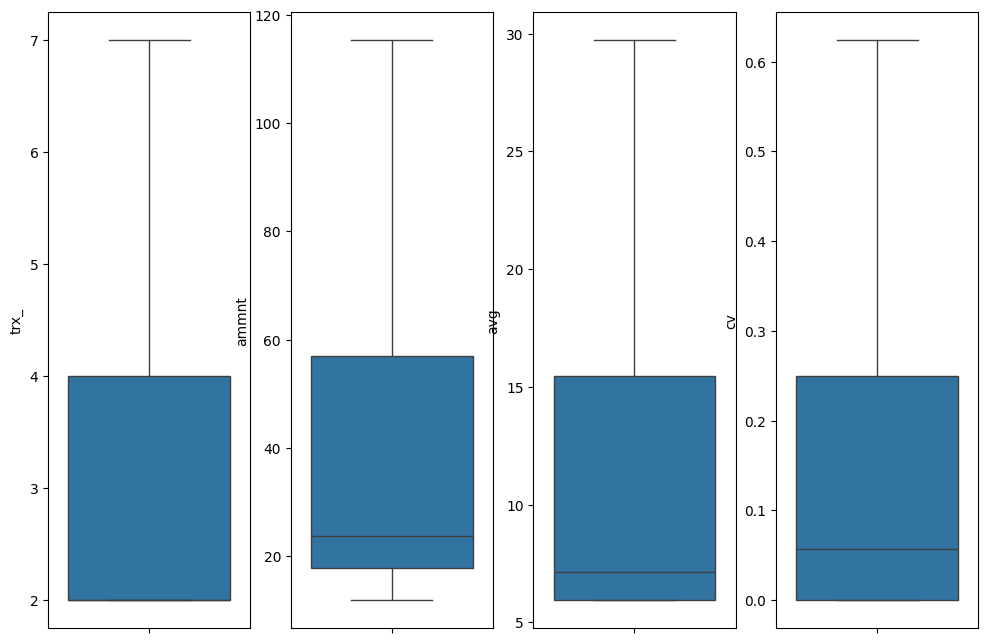

In [21]:
# Reglas heurísticas
def metrica(var): 
    mean = X[var].mean()
    std = X[var].std() # /((X['trx_'].shape[0])**(0.5))
    ucl = mean + 3 * std
    lcl = np.where(mean - 3 * std < 0, 0, mean - 3 * std)
    return ucl, lcl, mean

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
sns.boxplot(y="trx_", data= trx_an_cre, showfliers=False, ax = axes[0])
sns.boxplot(y="ammnt", data= trx_an_cre, showfliers=False, ax = axes[1])
sns.boxplot(y="avg", data= trx_an_cre, showfliers=False, ax = axes[2])
sns.boxplot(y="cv", data= trx_an_cre, showfliers=False, ax = axes[3])


In [22]:
# Selección de anomalías

features_df['heur_anomaly'] = np.where((features_df['trx_'] > metrica('trx_')[0]) & ((features_df['avg'] < metrica('avg')[2]) | (features_df['cv'] < metrica('cv')[2])), 1, 0)

features_df[features_df['heur_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,dbscan_cluster,dbscan_anomaly,heur_anomaly
496,CREDITO,00c67e61a803dc89bf5894b07d101d7f,20210114,35,208.118937,5.946255,0.000101,0,-0.554387,0,0,1
497,CREDITO,00c67e61a803dc89bf5894b07d101d7f,20210115,34,208.823949,6.141881,0.186132,1,-0.604551,0,0,1
1137,CREDITO,01c2e0350f7d77f4084502861b4989ff,20210121,51,303.293228,5.946926,0.000169,1,-0.611203,0,0,1
1138,CREDITO,01c2e0350f7d77f4084502861b4989ff,20210122,42,249.772922,5.946974,0.000148,1,-0.580255,0,0,1
1140,CREDITO,01c2e0350f7d77f4084502861b4989ff,20210131,93,553.054261,5.946820,0.000160,1,-0.716075,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
166303,CREDITO,fdfec36b1918e247de4549505920947b,20210106,100,696.877972,6.968780,1.124500,1,-0.768913,1,0,1
166767,CREDITO,fea26a25553aaa492f199c9ffe412dc8,20210106,100,594.679712,5.946797,0.000204,1,-0.714465,0,0,1
166768,CREDITO,fea26a25553aaa492f199c9ffe412dc8,20210123,32,202.148326,6.317135,0.332662,1,-0.608311,0,0,1
166769,CREDITO,fea26a25553aaa492f199c9ffe412dc8,20210124,59,1052.168537,17.833365,0.000000,1,-0.696461,0,0,1


##### 3.1.4 Ensamblaje

In [23]:
# Emsamblaje
features_df['ensemble_score'] = (features_df['if_anomaly'] + features_df['dbscan_anomaly'] + features_df['heur_anomaly'])
features_df['anomaly'] = (features_df['ensemble_score'] >= 2).astype(int)

In [24]:
# Hallázgos de anomalías por modelo
detection_summary = pd.DataFrame({
    'Isolation Forest': [features_df['if_anomaly'].sum(), f"{features_df['if_anomaly'].mean()*100:.1f}%"],
    'DBSCAN': [features_df['dbscan_anomaly'].sum(), f"{features_df['dbscan_anomaly'].mean()*100:.1f}%"],
    'Heurístico': [features_df['heur_anomaly'].sum(), f"{features_df['heur_anomaly'].mean()*100:.1f}%"],
    'Ensemble': [features_df['anomaly'].sum(), f"{features_df['anomaly'].mean()*100:.1f}%"]
}, index=['Anomalías Detectadas', 'Porcentaje'])

print("Resumen de detecciones por modelo:")
print(detection_summary)

Resumen de detecciones por modelo:
                     Isolation Forest DBSCAN Heurístico Ensemble
Anomalías Detectadas             4930     85       1069      852
Porcentaje                       9.8%   0.2%       2.1%     1.7%


##### 3.1.5 Análisis de resultados

In [25]:
# Análisis de casos detectados por el modelo ensemble
suspicious_cases = features_df[features_df['anomaly'] == 1].sort_values('ensemble_score', ascending=False)

print(f"\nTop 10 casos detectados por el modelo ensemble:")

suspicious_cases[['transaction_type', 'date_1', 'trx_', 'ammnt', 'avg', 'cv', 'if_anomaly', 'dbscan_anomaly', 'heur_anomaly', 'heur_anomaly']].head(10)


Top 10 casos detectados por el modelo ensemble:


,transaction_type,date_1,trx_,ammnt,avg,cv,if_anomaly,dbscan_anomaly,heur_anomaly,heur_anomaly
14113,CREDITO,20210109,35,487.524967,13.929285,3.390341,1,1,1,1
38949,CREDITO,20210128,75,529.075518,7.054340,1.267356,1,1,1,1
20477,CREDITO,20210109,94,709.502805,7.547902,1.379380,1,1,1,1
58831,CREDITO,20210109,41,416.206962,10.151389,2.652080,1,1,1,1
55890,CREDITO,20210125,43,957.154746,22.259413,3.785262,1,1,1,1
6458,CREDITO,20210110,89,612.479789,6.881795,1.282574,1,1,1,1
34253,CREDITO,20210105,57,373.581653,6.554064,0.589686,1,1,1,1
56735,CREDITO,20210126,69,538.567624,7.805328,0.543242,1,1,1,1
53558,CREDITO,20210109,49,491.223606,10.024972,2.846168,1,1,1,1
76161,CREDITO,20210130,67,464.932471,6.939291,1.151056,1,1,1,1


C:\Users\egarcmor\AppData\Local\Temp\ipykernel_21060\3612912157.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_21060\3612912157.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_21060\3612912157.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showflie

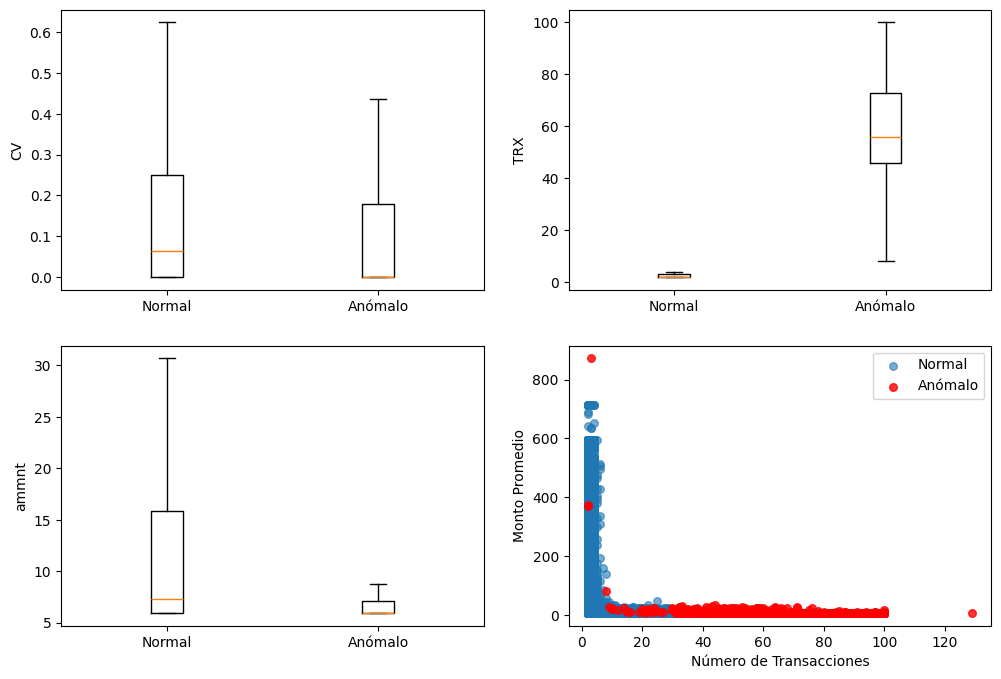

In [26]:
# Características de casos anómalos vs normales
normal = features_df[features_df['anomaly'] == 0]
anomalous = features_df[features_df['anomaly'] == 1]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Coeficiente de variación de montos
plt.subplot(2, 2, 1)
plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('CV')
plt.ylabel('CV')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 2)
plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('TRX')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 3)
plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('ammnt')

# trx x ammnt 
plt.subplot(2, 2, 4)
plt.scatter(normal['trx_'], normal['avg'], alpha=0.6, label='Normal', s=30)
plt.scatter(anomalous['trx_'], anomalous['avg'], alpha=0.8, label='Anómalo', s=30, c='red')
plt.xlabel('Número de Transacciones')
plt.ylabel('Monto Promedio')
#plt.title('Casos Normales vs Anomalías')
plt.legend()


<Axes: >

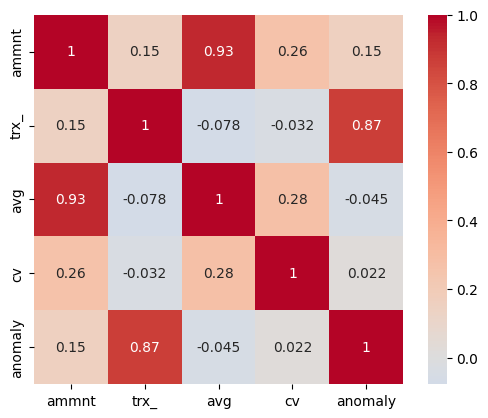

In [27]:
# Matriz de correlación de características principales

correlation_features = ['ammnt', 'trx_', 'avg', 'cv', 'anomaly']
corr_matrix = features_df[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)


#### Paso 3.2: Modelo para trx débito

In [28]:
feature_columns = ['trx_', 'avg', 'cv']# , 'ammnt',
X = trx_an_deb[feature_columns].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### 3.2.1 Isolation Forest

In [29]:
# Isolation forest
if_model = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
if_predictions = if_model.fit_predict(X_scaled)
if_scores = if_model.score_samples(X_scaled)

features_df = trx_an_deb.copy()
features_df['if_anomaly'] = (if_predictions == -1).astype(int)
features_df['if_score'] = if_scores

In [30]:
features_df[features_df['if_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score
167568,DEBITO,00096c0edca521aa514abf4c7767fbcc,20210114,4,463.667491,115.916873,1.392192,1,-0.656357
167635,DEBITO,001366c2710ad30d510bf1170bb61448,20210112,5,3007.894236,601.578847,0.415396,1,-0.610529
167961,DEBITO,004962ef675d210a8aaddac0f376a28a,20210104,4,1735.780864,433.945216,0.759749,1,-0.590180
167970,DEBITO,004a121e550cf799563611a3ebec782b,20210103,4,99.866844,24.966711,0.912664,1,-0.588171
167971,DEBITO,004a121e550cf799563611a3ebec782b,20210104,4,51.122313,12.780578,0.946753,1,-0.590428
...,...,...,...,...,...,...,...,...,...
630364,DEBITO,ffbfb09bfe66bb7cb5523626bd939447,20210126,2,713.334601,356.667301,1.319933,1,-0.568872
630396,DEBITO,ffc6e5bda8792ccbe9ef575f94fc4ff7,20210108,3,974.890622,324.963541,1.066219,1,-0.580013
630409,DEBITO,ffc9736b4d9f0e3bc35dca41fabda241,20210125,2,737.112422,368.556211,1.322974,1,-0.569337
630514,DEBITO,ffe087343f4c8aad20e37122eac9b85c,20210108,58,344.842591,5.945562,0.000201,1,-0.655397


##### 3.2.2 DBSCAN

In [31]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
features_df['dbscan_cluster'] = dbscan_labels
features_df['dbscan_anomaly'] = (dbscan_labels == -1).astype(int)

In [32]:
features_df[features_df['dbscan_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,dbscan_cluster,dbscan_anomaly
185597,DEBITO,09ef9d0c0923b7f4848655f0de449603,20210109,79,1742.319764,22.054681,0.572719,1,-0.749037,-1,1
185598,DEBITO,09ef9d0c0923b7f4848655f0de449603,20210111,62,1307.780102,21.093227,0.544072,1,-0.728471,-1,1
185600,DEBITO,09ef9d0c0923b7f4848655f0de449603,20210120,83,1676.930758,20.203985,0.496821,1,-0.748772,-1,1
192782,DEBITO,0dd3e961a5b7328a7491cf2276caca11,20210115,22,208.082081,9.458276,1.741907,1,-0.722953,-1,1
196557,DEBITO,0ff36dad15dc31bed02c840d1c777963,20210123,31,428.025727,13.807282,1.627616,1,-0.724577,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
589695,DEBITO,e996e08fb1f7ee5f259a2031a931073d,20210130,66,653.890051,9.907425,0.570020,1,-0.721100,-1,1
590236,DEBITO,e9e030b082b2c004a385916046c677a9,20210109,86,743.161499,8.641413,2.892946,1,-0.784744,-1,1
599819,DEBITO,eefbc8d3ff3a5b0200d385aa2e894035,20210101,71,535.317196,7.539679,1.777732,1,-0.774642,-1,1
604172,DEBITO,f177df9b33a7026d4e5fa32ab8c766c7,20210121,84,642.095063,7.643989,1.320002,1,-0.768379,-1,1


##### 3.2.3 Reglas heurísticas

<Axes: ylabel='cv'>

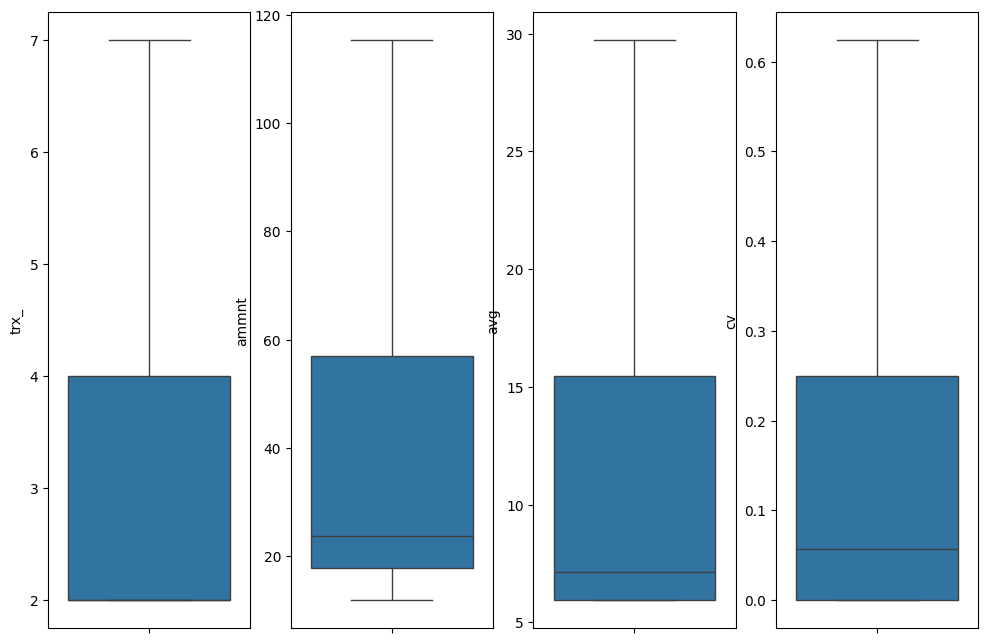

In [33]:
# Reglas heurísticas
def metrica(var): 
    mean = X[var].mean()
    std = X[var].std() # /((X['trx_'].shape[0])**(0.5))
    ucl = mean + 3 * std
    lcl = np.where(mean - 3 * std < 0, 0, mean - 3 * std)
    return ucl, lcl, mean

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
sns.boxplot(y="trx_", data= trx_an_cre, showfliers=False, ax = axes[0])
sns.boxplot(y="ammnt", data= trx_an_cre, showfliers=False, ax = axes[1])
sns.boxplot(y="avg", data= trx_an_cre, showfliers=False, ax = axes[2])
sns.boxplot(y="cv", data= trx_an_cre, showfliers=False, ax = axes[3])

In [34]:
# Selección de anomalías
features_df['heur_anomaly'] = np.where((features_df['trx_'] > metrica('trx_')[0]) & ((features_df['avg'] < metrica('avg')[2]) | (features_df['cv'] < metrica('cv')[2])), 1, 0)
features_df[features_df['heur_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,dbscan_cluster,dbscan_anomaly,heur_anomaly
168775,DEBITO,00bf77a52b635dd43c01384fa5e97346,20210124,78,463.667491,5.944455,0.000000,1,-0.713736,0,0,1
168831,DEBITO,00c67e61a803dc89bf5894b07d101d7f,20210111,83,493.533622,5.946188,0.000100,1,-0.722445,0,0,1
170525,DEBITO,01c2e0350f7d77f4084502861b4989ff,20210121,48,287.579655,5.991243,0.029030,1,-0.651780,0,0,1
170526,DEBITO,01c2e0350f7d77f4084502861b4989ff,20210122,52,309.238872,5.946901,0.000160,1,-0.645716,0,0,1
170527,DEBITO,01c2e0350f7d77f4084502861b4989ff,20210131,100,594.677335,5.946773,0.000162,1,-0.737904,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
628571,DEBITO,fea26a25553aaa492f199c9ffe412dc8,20210104,75,445.918537,5.945580,0.000200,1,-0.702830,0,0,1
628573,DEBITO,fea26a25553aaa492f199c9ffe412dc8,20210112,89,529.163496,5.945657,0.000201,1,-0.727536,0,0,1
628575,DEBITO,fea26a25553aaa492f199c9ffe412dc8,20210129,100,594.445501,5.944455,0.000000,1,-0.738903,0,0,1
629615,DEBITO,ff43efd9e35916f280da2cdd0be14d76,20210121,95,564.723226,5.944455,0.000000,1,-0.729980,0,0,1


##### 3.2.4 Ensamblaje

In [35]:
# Emsamblaje
features_df['ensemble_score'] = (features_df['if_anomaly'] + features_df['dbscan_anomaly'] + features_df['heur_anomaly'])
features_df['anomaly'] = (features_df['ensemble_score'] >= 2).astype(int)

In [36]:
# Hallázgos de anomalías por modelo
detection_summary = pd.DataFrame({
    'Isolation Forest': [features_df['if_anomaly'].sum(), f"{features_df['if_anomaly'].mean()*100:.1f}%"],
    'DBSCAN': [features_df['dbscan_anomaly'].sum(), f"{features_df['dbscan_anomaly'].mean()*100:.1f}%"],
    'Heurístico': [features_df['heur_anomaly'].sum(), f"{features_df['heur_anomaly'].mean()*100:.1f}%"],
    'Ensemble': [features_df['anomaly'].sum(), f"{features_df['anomaly'].mean()*100:.1f}%"]
}, index=['Anomalías Detectadas', 'Porcentaje'])

print("Resumen de detecciones por modelo:")
print(detection_summary)

Resumen de detecciones por modelo:
                     Isolation Forest DBSCAN Heurístico Ensemble
Anomalías Detectadas             6899     64       1185     1208
Porcentaje                      10.0%   0.1%       1.7%     1.8%


##### 3.2.5 Análisis de resultados

In [37]:
# Análisis de casos detectados por el modelo ensemble
suspicious_cases = features_df[features_df['anomaly'] == 1].sort_values('ensemble_score', ascending=False)

print(f"\nTop 10 casos detectados por el modelo ensemble:")

suspicious_cases[['transaction_type', 'date_1', 'trx_', 'ammnt', 'avg', 'cv', 'if_anomaly', 'dbscan_anomaly', 'heur_anomaly', 'heur_anomaly']].head(10)


Top 10 casos detectados por el modelo ensemble:


,transaction_type,date_1,trx_,ammnt,avg,cv,if_anomaly,dbscan_anomaly,heur_anomaly,heur_anomaly
371379,DEBITO,20210129,48,400.656268,8.347006,0.449924,1,1,1,1
232939,DEBITO,20210114,74,527.476460,7.128060,1.415265,1,1,1,1
342720,DEBITO,20210109,32,416.146329,13.004573,3.070594,1,1,1,1
280388,DEBITO,20210120,100,824.852577,8.248526,1.031117,1,1,1,1
294614,DEBITO,20210129,57,577.563249,10.132689,0.570046,1,1,1,1
196557,DEBITO,20210123,31,428.025727,13.807282,1.627616,1,1,1,1
316757,DEBITO,20210109,34,243.760700,7.169432,0.995345,1,1,1,1
185597,DEBITO,20210109,79,1742.319764,22.054681,0.572719,1,1,1,1
185598,DEBITO,20210111,62,1307.780102,21.093227,0.544072,1,1,1,1
316883,DEBITO,20210104,68,428.086361,6.295388,0.458007,1,1,1,1


C:\Users\egarcmor\AppData\Local\Temp\ipykernel_21060\2891077651.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_21060\2891077651.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_21060\2891077651.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showflie

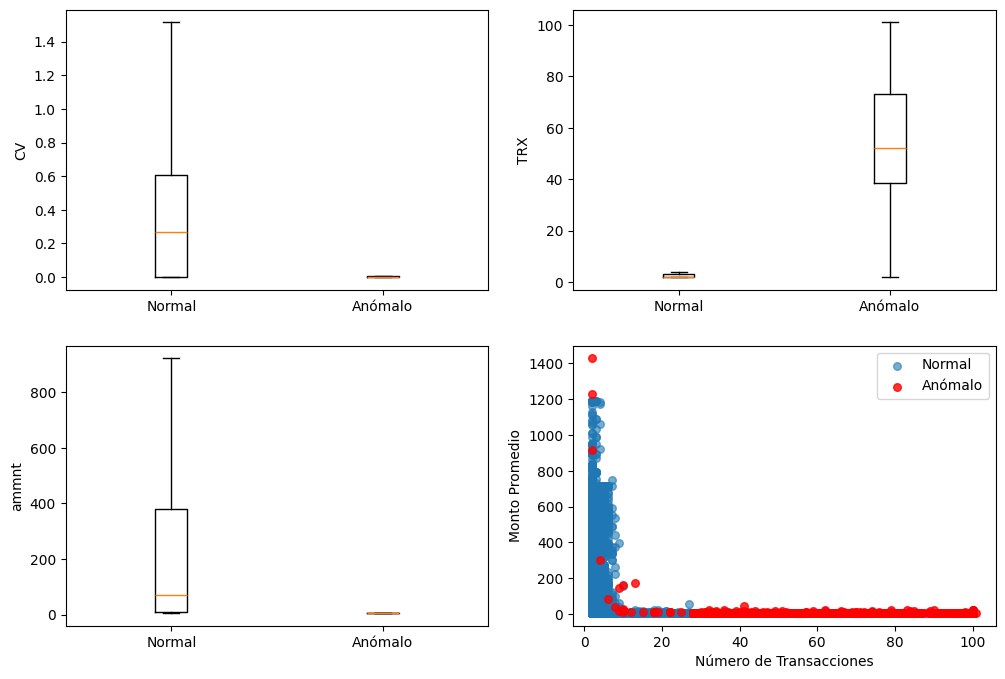

In [38]:
# Características de casos anómalos vs normales
normal = features_df[features_df['anomaly'] == 0]
anomalous = features_df[features_df['anomaly'] == 1]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Coeficiente de variación de montos
plt.subplot(2, 2, 1)
plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('CV')
plt.ylabel('CV')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 2)
plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('TRX')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 3)
plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('ammnt')

# trx x ammnt 
plt.subplot(2, 2, 4)
plt.scatter(normal['trx_'], normal['avg'], alpha=0.6, label='Normal', s=30)
plt.scatter(anomalous['trx_'], anomalous['avg'], alpha=0.8, label='Anómalo', s=30, c='red')
plt.xlabel('Número de Transacciones')
plt.ylabel('Monto Promedio')
#plt.title('Casos Normales vs Anomalías')
plt.legend()

### Paso 3.3: Frecuencia de actualización de datos

Luego de analizar algunos casos de usuarios con transacciones anómalas, se observa que estas transacciones ocurren en el trascurso de minutos. Por lo que la frecuencia debería al menos de actualización cada minuto siendo ideal, actualización cada 15 o 20 segundos. A continuación se muestra el soporte de esta recomendación.

In [39]:
# Transacciones por usr
df_1_sample_ex = df_1_sample[df_1_sample['date_1']==20210110].copy()
trx_freq = pd.DataFrame(df_1_sample_ex['user_id'].value_counts()).reset_index()
trx_freq.columns = ['user_id', 'n_trx']
#print(trx_usr[trx_usr['n_trx']>1].shape)
trx_freq.head()

,user_id,n_trx
0,55053ead9cf922c4b96d7003c2f7cfb6,157
1,507e9e33c91804804a351de40e160b47,151
2,316da47ffafffd546acf7be665bcd309,126
3,8d5e4a03dde0a2fd8abe6a8557fefe60,111
4,e2944117310fcd4690f5b4639bda45bb,108


In [40]:
df_1_sample_ex['fecha'] = pd.to_datetime(df_1_sample_ex['fecha'])
df_1_sample_ex['hora'] = df_1_sample_ex['fecha'].dt.hour
df_1_sample_ex['minuto'] = df_1_sample_ex['fecha'].dt.minute

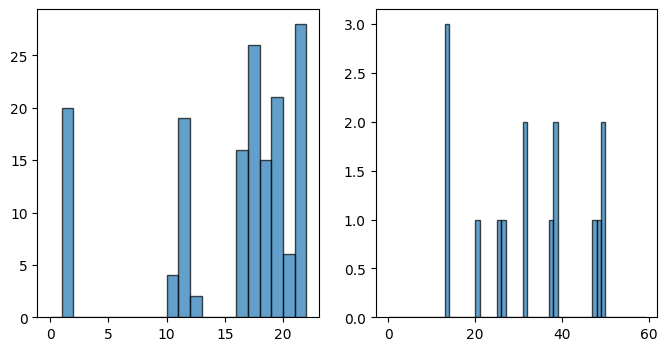

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Distribución de trx por hora para un caso anómalo
plt.subplot(1, 2, 1)
plt.hist(df_1_sample_ex[df_1_sample_ex['user_id']=='55053ead9cf922c4b96d7003c2f7cfb6']['hora'], bins=range(0, 23), alpha=0.7, edgecolor='black')

# Distribución de trx por minuto para un caso anómalo
plt.subplot(1, 2, 2)
plt.hist(df_1_sample_ex[(df_1_sample_ex['user_id']=='55053ead9cf922c4b96d7003c2f7cfb6') & (df_1_sample_ex['hora']==18)]['minuto'], bins=range(0, 60), alpha=0.7, edgecolor='black')
plt.show()


In [42]:
df_1_sample_ex[(df_1_sample_ex['user_id']=='55053ead9cf922c4b96d7003c2f7cfb6') & (df_1_sample_ex['hora']==18)]

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha,date_1,hora,minuto
10395383,838a8fa992a4aa2fb5a0cf8b15b63755,4dc6564fc9b44156f6e7c2606aa1d862,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:13:06,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94564390,CREDITO,2021-01-10 18:13:06,20210110,18,13
9712651,838a8fa992a4aa2fb5a0cf8b15b63755,4a7f266b1b86992f0b7ab50a7c8cd12d,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:13:32,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94683279,DEBITO,2021-01-10 18:13:32,20210110,18,13
10395396,838a8fa992a4aa2fb5a0cf8b15b63755,281b3878294df5e4223de87d01f8146a,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:13:47,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:13:47,20210110,18,13
10395355,838a8fa992a4aa2fb5a0cf8b15b63755,7e91a93db6580b68fdab17b87f36f1c1,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:20:31,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:20:31,20210110,18,20
10395350,838a8fa992a4aa2fb5a0cf8b15b63755,830846fa44b5e248583edecd88160d4b,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:25:36,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94564390,CREDITO,2021-01-10 18:25:36,20210110,18,25
10395371,838a8fa992a4aa2fb5a0cf8b15b63755,67292a3a78a4e403e97ea1e9ace12227,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:26:21,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:26:21,20210110,18,26
9712658,838a8fa992a4aa2fb5a0cf8b15b63755,52649d8c06e89b4609dc83b8c37fdf96,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:31:45,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94683279,DEBITO,2021-01-10 18:31:45,20210110,18,31
10395393,838a8fa992a4aa2fb5a0cf8b15b63755,77ad421138964f3d3ef566890ced101a,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:31:59,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:31:59,20210110,18,31
9712661,838a8fa992a4aa2fb5a0cf8b15b63755,57cbec6f392c8ded4ebc1f1cea610c88,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:37:35,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94445501,DEBITO,2021-01-10 18:37:35,20210110,18,37
9712629,838a8fa992a4aa2fb5a0cf8b15b63755,6364f7df156480ea274213da92ce5037,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:38:23,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94683279,DEBITO,2021-01-10 18:38:23,20210110,18,38


### Paso 3.4: Arquitectura ideal y recursos necesarios

Una posible arquitectura para desplegar esta propuesta es usar la infraestructura de AWS. Para ello se hace uso de los servicios de Glue, S3, Athena, Sagemaker y Quicksight. 

- En S3 + Athena se realiza el almacenamiento de la información y la realización de consultas a SQL.
- En Glue se hace el tema de ingeniería de datos y preprocesamiento de la información. La cual se almacena en un S3 para que quede de fácil consumo para el modelado en Sagemaker.
- En Sagemaker se genera el modelado y la construcción de pipeline para la ejecución frecuente (cada minuto)
- Y en quicksight, se construye el dashboard  para monitoreo de las anomalías

## Fin